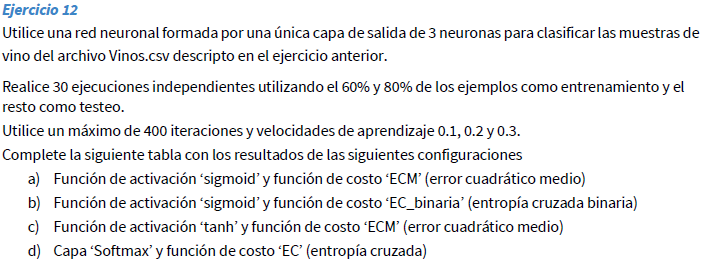

In [2]:
# configuración para notebook con instalación LOCAL
FUENTES_DIR  = '../../Datos-Fuentes/Fuentes/'     # carpeta donde se encuentran archivos .py auxiliares
DATOS_DIR    = '../../Datos-Fuentes/Datos/'      # carpeta donde se encuentran los datasets
MODELOS_DIR  = '../Modelos/'    # carpeta donde se encuentran los modelos
ARCHIVOs_DIR = '../Archivos/'   # carpeta recuperar o copiar archivos

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

In [4]:
import pandas as pd      # para trabajar con archivos de datos csv, excel, etc: https://pandas.pydata.org/docs/getting_started/tutorials.html
import chardet           # para detectar la codificación de texto en archivos

nombre_archivo = DATOS_DIR + 'Vinos.csv' # archivo de hojas

#-- detectando la codificación de caracteres usada ----
with open(nombre_archivo, 'rb') as f:
    result = chardet.detect(f.read())  # or readline if the file is large

# recupera el archivo en un objeto dataframe de pandas utilizando la codificación detectada
df = pd.read_csv(nombre_archivo, encoding=result['encoding'], sep=";")

display(df)

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


## Seleccion de atributos y normalizacion

In [5]:
import numpy as np
from sklearn import preprocessing

# %% separa atributos para entrenar de clases
X_raw = np.array(df.iloc[:,1::])  # recupera todas las columnas salvo la primera (es la clase)
T_raw = np.array(df.iloc[:,0])    # recupera solo la primera columna (es la clase)

clases = np.unique(T_raw)  # obtiene las clases sin repeticiones
print('Las clases del dataset son :', clases)

# Normalizacion con media y desviacion
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X_raw)

T_raw = T_raw.reshape((-1,1))   # fuerza formato (N,1) sino es (N,)

# los target deben tener formato one hot.
# clase 1 => 100 | clase 2 => 010 | clase 3 => 001
encoder = preprocessing.OneHotEncoder(handle_unknown='ignore')
T = encoder.fit_transform(T_raw.reshape(-1,1)).toarray()


Las clases del dataset son : [1 2 3]


## Entrenamiento de neurona multiclase

In [16]:
from sklearn import model_selection
from ClassRNMulticlase import RNMulticlase

###############################################################################
# neurona multiclase con sigmoid y ECM
ERROR = 1e-03
ALFA = 0.2
#FUN = 'sigmoid'
#FUN = 'tanh'
FUN = 'softmax'
MAX_ITE = 400
CORRIDAS = 30
TEST_SIZE = .2
#COSTO = 'ECM'
COSTO = 'EC'
#COSTO = 'EC_binaria'

print('\nNeurona con %s' %FUN)

prom_ite = 0
prom_acc_train = 0
prom_acc_test = 0
veces_train = 0
veces_test = 0

for nro_ite in range(CORRIDAS):
    # Establece resultado esperado según la clase. 1=clase esperada, 0=otra clase

    if FUN == 'tanh':
        T_new = 2*T-1
        pass
    else:
        T_new = T

    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, T_new, test_size=TEST_SIZE)#, random_state=42)

    # Entrena perceptrón
    modelo = RNMulticlase(alpha=ALFA, n_iter=MAX_ITE, FUN=FUN, COSTO=COSTO, cotaE=ERROR)
    modelo.fit(X_train, Y_train)

    (W, b, iteraciones) = (modelo.w_, modelo.b_, len(modelo.errors_))

    prom_ite = prom_ite + iteraciones

    # efectividad entrenamiento
    efectividad = 100*modelo.accuracy(X_train, Y_train)

    prom_acc_train = prom_acc_train + efectividad
    if (100-efectividad>0.0000001):
      veces_train = veces_train + 1
    print("E %6.2f%% de efectividad con %d iteraciones" % (efectividad, iteraciones ))
    # efectividad testeo
    efectividad = 100*modelo.accuracy(X_test, Y_test)

    prom_acc_test = prom_acc_test + efectividad
    if (100-efectividad>0.0000001):
      veces_test = veces_test + 1

    print("T %6.2f%% de efectividad con %d iteraciones" % (efectividad, iteraciones ))

print('promedio iteraciones  : %6.2f' % (prom_ite/CORRIDAS))
print('promedio acc. train   : %6.2f' % (prom_acc_train/CORRIDAS))
print('promedio acc. test    : %6.2f' % (prom_acc_test/CORRIDAS))
print('ejec. train con 100%%  : %3d' % (veces_train))
print('ejec.  test con 100%%  : %3d' % (veces_test))


Neurona con softmax
E  99.30% de efectividad con 12 iteraciones
T  94.44% de efectividad con 12 iteraciones
E  98.59% de efectividad con 15 iteraciones
T  88.89% de efectividad con 15 iteraciones
E  97.18% de efectividad con 9 iteraciones
T 100.00% de efectividad con 9 iteraciones
E  98.59% de efectividad con 13 iteraciones
T  88.89% de efectividad con 13 iteraciones
E  98.59% de efectividad con 23 iteraciones
T  91.67% de efectividad con 23 iteraciones
E  97.18% de efectividad con 11 iteraciones
T 100.00% de efectividad con 11 iteraciones
E  97.18% de efectividad con 14 iteraciones
T  91.67% de efectividad con 14 iteraciones
E  97.89% de efectividad con 16 iteraciones
T  91.67% de efectividad con 16 iteraciones
E  97.89% de efectividad con 11 iteraciones
T  97.22% de efectividad con 11 iteraciones
E 100.00% de efectividad con 27 iteraciones
T  91.67% de efectividad con 27 iteraciones
E  97.89% de efectividad con 8 iteraciones
T  94.44% de efectividad con 8 iteraciones
E  99.30% de ef